In [2]:
from __future__ import division
from math import *
import numpy as np
import sys
import os
from matplotlib.ticker import LogFormatter
from matplotlib.ticker import LogFormatterExponent
from matplotlib.ticker import LogFormatterSciNotation

import pandas as pd
import numpy as np
import matplotlib, os
import matplotlib.pyplot as plt
# Matplotlib configuration
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
matplotlib.style.use('classic')
plt.rcParams['xtick.direction']     = 'in'
plt.rcParams['ytick.direction']     = 'in'
plt.rcParams['xtick.top']           = True
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.right']         = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
import matplotlib.cm as cm

from matplotlib import pyplot
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
matplotlib.rc('text', usetex = True)
matplotlib.rc('font', **{'family' : "sans-serif"})
params= {'text.latex.preamble' : [r'\usepackage{amssymb}']}
pyplot.rcParams.update(params)

from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import FuncFormatter
from scipy.interpolate import griddata
from scipy.interpolate import interp1d

import sys
sys.path.append("/Users/oozdal/packages/ma5-histo")
sys.path.append("/Users/oozdal/packages/ma5_expert")

import src.SafReader as sr
from CutFlowReader import Collection 

import scipy.stats
from scipy.spatial import distance

import math

In [3]:
def df(fileLoc):
    data = sr.read(fileLoc=fileLoc)
    floatCols=['binMin', 'binMax', 'value']
    data[floatCols]  = data[floatCols].apply(pd.to_numeric, errors='coerce')
    data["bin"]      = (data.binMin+data.binMax)/2
    data             = data[data.binMax != np.inf]
    data             = data[data.binMin != -1*np.inf]
    data["binlabel"] = (data.binMin+data.binMax)/2
    return data

In [4]:
def unc(observable, Nevt):
    return np.sqrt((1-observable**2)/Nevt)

def sig(O1, O2, Nevt1, Nevt2):
    return abs(O1-O2)/np.sqrt( unc(O2,Nevt2)**2 ) # + O1*unc(O1,Nevt1)**2 )

def jensen_shannon_distance(p, q):
    """
    method to compute the Jenson-Shannon Distance 
    between two probability distributions
    """

    # convert the vectors into numpy arrays in case that they aren't
    p = np.array(p)
    q = np.array(q)

    # calculate m
    m = (p + q) / 2

    # compute Jensen Shannon Divergence
    divergence = (scipy.stats.entropy(p, m) + scipy.stats.entropy(q, m)) / 2

    # compute the Jensen Shannon Distance
    distance = np.sqrt(divergence)

    return distance

def KLD(p, q):
    """
    Elementwise function for computing Kullback-Leibler divergence.
    """
    
    # convert the vectors into numpy arrays in case that they aren't
    p = np.array(p)
    q = np.array(q)   

    # compute Kullback-Leibler divergence
    kl_div = scipy.special.kl_div(p, q)

    return kl_div

def sigmoid(x):
    
    x = np.array(x)
    return 1 / (1 + math.exp(-x))

In [5]:
lumi=3000.

# Standard Model 

In [151]:
AFB_data = '/Users/oozdal/projects/SSM_WpZp/AFB_data'

SM = Collection(collection_path= AFB_data+'/SMll_Mll4500and8000/MadAnalysis5job_0/Cutflows',
                    saf_file       = AFB_data+'/SMll_Mll4500and8000/SMll_Mll4500and8000.saf',
                    lumi           = 3000.)
SM_sumw   = SM['Rap_No'][0].sumw
SM_histos = df(AFB_data+'/SMll_Mll4500and8000/MadAnalysis5job_0/Histograms/histos.saf')

In [152]:
SM_df = pd.read_csv('/Users/oozdal/projects/SSM_WpZp/AFB_data/SM.csv', header=0, sep=",")
SM_df.columns = ["Mll", "angle_CM_true", "angle_CM_rec", "cos_angle_CM_star", "Eta_lp", "Eta_lm", "Mll_Boosted", "Eta_Boosted_lp", "Eta_Boosted_lm", "quarkcharge",
"Lepton_Charge","yll_lab", "yll_CM","EvWeight"]

Let's apply some bounds

In [153]:
SM_df = SM_df[ (SM_df["Mll"] >= 5400.)  & (SM_df["Mll"] <= 6600.) ]      # Mll [5-6] TeV
SM_df = SM_df[ (SM_df["Eta_lp"] <= 2.5) & (SM_df["Eta_lm"] <= 2.5) ]     # Eta(lepton) < 2.5
SM_df = SM_df[ (SM_df["Lepton_Charge"] < 0.) ]  # We will compute AFB using negatively charged leptons. Therefore we don't need positive leptons! 

# True AFB Components for the SM

In [154]:
SM_AFB_pos = SM_df[ np.cos(SM_df["angle_CM_true"]) > 0. ]
SM_AFB_neg = SM_df[ np.cos(SM_df["angle_CM_true"]) < 0. ]

BinNumber = 12
BinFirst  = 5400.
BinLast   = 6600.

StepSize = (BinLast - BinFirst)/BinNumber
bins = []
bins.append(BinFirst)

for i in range(BinNumber): 
    BinFirst = BinFirst + StepSize
    bins.append(BinFirst)

#bins = [5400.0, 5900.0, 6000.0, 6100.0, 6600.0] 


TotEvWeight_LepPos_List1 = []
TotEvWeight_LepNeg_List1 = []

TotEvWeight_LepPos_List2 = []
TotEvWeight_LepNeg_List2 = []


i=0
for i in range(len(bins)-1):
    Box_LepPos = SM_AFB_pos[:][ (SM_AFB_pos["Mll"]>bins[i]) & (SM_AFB_pos["Mll"]<bins[i+1]) ]
    TotEvWeight_LepPos = len(Box_LepPos["EvWeight"])
    TotEvWeight_LepPos_List1.append(TotEvWeight_LepPos)
    TotEvWeight_LepPos = sum(Box_LepPos["EvWeight"])
    TotEvWeight_LepPos_List2.append(TotEvWeight_LepPos)
       
    Box_LepNeg = SM_AFB_neg[:][ (SM_AFB_neg["Mll"]>bins[i]) & (SM_AFB_neg["Mll"]<bins[i+1]) ]
    TotEvWeight_LepNeg = len(Box_LepNeg["EvWeight"])
    TotEvWeight_LepNeg_List1.append(TotEvWeight_LepNeg)
    TotEvWeight_LepNeg = sum(Box_LepNeg["EvWeight"])
    TotEvWeight_LepNeg_List2.append(TotEvWeight_LepNeg)       
    
TotEvWeight_LepPos_Arr1 = np.array(TotEvWeight_LepPos_List1)
TotEvWeight_LepNeg_Arr1 = np.array(TotEvWeight_LepNeg_List1)

TotEvWeight_LepPos_Arr2 = np.array(TotEvWeight_LepPos_List2)
TotEvWeight_LepNeg_Arr2 = np.array(TotEvWeight_LepNeg_List2)

AFB_num = TotEvWeight_LepPos_Arr1 - TotEvWeight_LepNeg_Arr1
AFB_den = TotEvWeight_LepPos_Arr1 + TotEvWeight_LepNeg_Arr1

AFB_SM     = AFB_num/np.where(AFB_den==0,1e10,AFB_den)

SM_totsumw = sum(TotEvWeight_LepPos_Arr2)+sum(TotEvWeight_LepNeg_Arr2)

#Number of Events
NumofEvents_LepPos_SM = TotEvWeight_LepPos_Arr2*lumi*SM.xsec*1000/SM_sumw
NumofEvents_LepNeg_SM = TotEvWeight_LepNeg_Arr2*lumi*SM.xsec*1000/SM_sumw

# LRSM (Case: Gluion Is Jet)

In [11]:
AFB_data = '/Users/oozdal/projects/EffWR_Asymmetry/AFB_Outputs'

LRSM = Collection(collection_path = AFB_data+'/EffWRtolljj_NLO_gluisjet/MadAnalysis5job_0/Cutflows',
                    xsection      = 7.071785e-04,
                    lumi          = 3000.)
LRSM_sumw   = LRSM['Rap_No'][0].sumw

In [12]:
LRSM_df = pd.read_csv('/Users/oozdal/projects/EffWR_Asymmetry/AFB_data/EffWRtolljj_NLO_gluisjet.csv', header=0, sep=",")
LRSM_df.columns = ["Mll", "Mll_boosted", "Mjj", "Mlljj", "MET", "MT", "MHT", "Angle_CM_true", "Angle_CM_rec", "Eta_Boosted_lp", "Eta_Boosted_lm", "Eta_lp", "Eta_lm", "Quark Charge", 
                   "Lepton Charge", "yll_lab", "yll_CM", "hasOS", "ml1jj", "ml2jj", "mlpjj", "mlmjj", "EvWeight"]

Let's apply some bounds

In [13]:
LRSM_df_OS = LRSM_df[ (LRSM_df["hasOS"] > 0.) ]
LRSM_df_SS = LRSM_df[ (LRSM_df["hasOS"] == 0.) ]

LRSM_df_lm = LRSM_df[ (LRSM_df["Lepton Charge"] < 0.) ]  # We will compute AFB using negatively charged leptons. 
LRSM_df_lp = LRSM_df[ (LRSM_df["Lepton Charge"] > 0.) ]  # positive leptons! 

LRSM_df_OS_lm = LRSM_df_OS[ (LRSM_df_OS["Lepton Charge"] < 0.) ]
LRSM_df_OS_lp = LRSM_df_OS[ (LRSM_df_OS["Lepton Charge"] < 0.) ]

LRSM_df_AFB_pos = LRSM_df_OS_lm[ np.cos(LRSM_df_OS_lm["Angle_CM_true"]) > 0. ]
LRSM_df_AFB_neg = LRSM_df_OS_lm[ np.cos(LRSM_df_OS_lm["Angle_CM_true"]) < 0. ]

#LRSM_df_AFB_pos = LRSM_df_lm[ np.cos(LRSM_df_lm["Angle_CM_true"]) > 0. ]
#LRSM_df_AFB_neg = LRSM_df_lm[ np.cos(LRSM_df_lm["Angle_CM_true"]) < 0. ]

# True AFB Components for LRSM

In [14]:
BinNumber = 12
BinFirst  = 5400.
BinLast   = 6600.

StepSize = (BinLast - BinFirst)/BinNumber
bins = []
bins.append(BinFirst)

for i in range(BinNumber): 
    BinFirst = BinFirst + StepSize
    bins.append(BinFirst)

#bins = [400.0, 1000.0, 1500.0, 2000.0, 2500.0, 3000.0, 3500.0, 4000.0, 4500.0, 5000.0, 5500.0, 6000.0, 7000.0]  # For Mlljj   
bins = [400.0, 1500.0, 2000.0, 2500.0, 3000.0, 3500.0, 4000.0, 5000.0, 7000.0]  # For AFB

TotEvWeight_LepPos_List1 = []
TotEvWeight_LepNeg_List1 = []

TotEvWeight_LepPos_List2 = []
TotEvWeight_LepNeg_List2 = []

###################################################################

# AFB
for i in range(len(bins)-1):
    Box_LepPos = LRSM_df_AFB_pos[:][ (LRSM_df_AFB_pos["Mlljj"]>bins[i]) & (LRSM_df_AFB_pos["Mlljj"]<bins[i+1]) ]
    TotEvWeight_LepPos = len(Box_LepPos["EvWeight"])
    TotEvWeight_LepPos_List1.append(TotEvWeight_LepPos)
    TotEvWeight_LepPos = sum(Box_LepPos["EvWeight"])
    TotEvWeight_LepPos_List2.append(TotEvWeight_LepPos)
       
    Box_LepNeg = LRSM_df_AFB_neg[:][ (LRSM_df_AFB_neg["Mlljj"]>bins[i]) & (LRSM_df_AFB_neg["Mlljj"]<bins[i+1]) ]
    TotEvWeight_LepNeg = len(Box_LepNeg["EvWeight"])
    TotEvWeight_LepNeg_List1.append(TotEvWeight_LepNeg)
    TotEvWeight_LepNeg = sum(Box_LepNeg["EvWeight"])
    TotEvWeight_LepNeg_List2.append(TotEvWeight_LepNeg)       
    
TotEvWeight_LepPos_Arr1 = np.array(TotEvWeight_LepPos_List1)
TotEvWeight_LepNeg_Arr1 = np.array(TotEvWeight_LepNeg_List1)

TotEvWeight_LepPos_Arr2 = np.array(TotEvWeight_LepPos_List2)
TotEvWeight_LepNeg_Arr2 = np.array(TotEvWeight_LepNeg_List2)

AFB_num = TotEvWeight_LepPos_Arr1 - TotEvWeight_LepNeg_Arr1
AFB_den = TotEvWeight_LepPos_Arr1 + TotEvWeight_LepNeg_Arr1

AFB_LRSM     = AFB_num/np.where(AFB_den==0,1e10,AFB_den)
print(AFB_LRSM)

LRSM_totsumw = sum(TotEvWeight_LepPos_Arr2)+sum(TotEvWeight_LepNeg_Arr2)

#Number of Events
NumofEvents_LepPos_LRSM = TotEvWeight_LepPos_Arr2*lumi*LRSM.xsec*1000/LRSM_sumw
NumofEvents_LepNeg_LRSM = TotEvWeight_LepNeg_Arr2*lumi*LRSM.xsec*1000/LRSM_sumw

##################################################################

# Total Number of Events (Positive and Negative Leptons Combined. In other words -> dictioary LRSM_df)
TotEvWeight_List1 = []
TotEvWeight_List2 = []

for i in range(len(bins)-1):
    Box = LRSM_df[:][ (LRSM_df["Mlljj"]>bins[i]) & (LRSM_df["Mlljj"]<bins[i+1]) ]
    TotEvWeight = len(Box["EvWeight"])
    TotEvWeight_List1.append(TotEvWeight)
    TotEvWeight = sum(Box["EvWeight"])
    TotEvWeight_List2.append(TotEvWeight)
             
TotEvWeight_Arr2 = np.array(TotEvWeight_List2)        
        
LRSM_totsumw = sum(TotEvWeight_Arr2)
NumofEvents_LRSM_Combined = TotEvWeight_Arr2*lumi*LRSM.xsec*1000/LRSM_sumw
print(NumofEvents_LRSM_Combined)

####################################################################

# Only OS Positively Charged Leptons

TotEvWeight_List1 = []
TotEvWeight_List2 = []

for i in range(len(bins)-1):
    Box = LRSM_df_OS_lp[:][ (LRSM_df_OS_lp["Mlljj"]>bins[i]) & (LRSM_df_OS_lp["Mlljj"]<bins[i+1]) ]
    TotEvWeight = len(Box["EvWeight"])
    TotEvWeight_List1.append(TotEvWeight)
    TotEvWeight = sum(Box["EvWeight"])
    TotEvWeight_List2.append(TotEvWeight)
             
TotEvWeight_Arr2 = np.array(TotEvWeight_List2)        
        
LRSM_totsumw = sum(TotEvWeight_Arr2)
NumofEvents_LRSM_lp = TotEvWeight_Arr2*lumi*LRSM.xsec*1000/LRSM_sumw
print(NumofEvents_LRSM_lp)

# Only OS Negatively Charged Leptons

TotEvWeight_List1 = []
TotEvWeight_List2 = []

for i in range(len(bins)-1):
    Box = LRSM_df_OS_lm[:][ (LRSM_df_OS_lm["Mlljj"]>bins[i]) & (LRSM_df_OS_lm["Mlljj"]<bins[i+1]) ]
    TotEvWeight = len(Box["EvWeight"])
    TotEvWeight_List1.append(TotEvWeight)
    TotEvWeight = sum(Box["EvWeight"])
    TotEvWeight_List2.append(TotEvWeight)
             
TotEvWeight_Arr2 = np.array(TotEvWeight_List2)        
        
LRSM_totsumw = sum(TotEvWeight_Arr2)
NumofEvents_LRSM_lm = TotEvWeight_Arr2*lumi*LRSM.xsec*1000/LRSM_sumw
print(NumofEvents_LRSM_lm)

# Only OS Charged Leptons
TotEvWeight_List1 = []
TotEvWeight_List2 = []

for i in range(len(bins)-1):
    Box = LRSM_df_OS[:][ (LRSM_df_OS["Mlljj"]>bins[i]) & (LRSM_df_OS["Mlljj"]<bins[i+1]) ]
    TotEvWeight = len(Box["EvWeight"])
    TotEvWeight_List1.append(TotEvWeight)
    TotEvWeight = sum(Box["EvWeight"])
    TotEvWeight_List2.append(TotEvWeight)
             
TotEvWeight_Arr2 = np.array(TotEvWeight_List2)        
        
LRSM_totsumw = sum(TotEvWeight_Arr2)
NumofEvents_LRSM_OS = TotEvWeight_Arr2*lumi*LRSM.xsec*1000/LRSM_sumw
print(NumofEvents_LRSM_OS)

# Only SS Charged Leptons
TotEvWeight_List1 = []
TotEvWeight_List2 = []

for i in range(len(bins)-1):
    Box = LRSM_df_SS[:][ (LRSM_df_SS["Mlljj"]>bins[i]) & (LRSM_df_SS["Mlljj"]<bins[i+1]) ]
    TotEvWeight = len(Box["EvWeight"])
    TotEvWeight_List1.append(TotEvWeight)
    TotEvWeight = sum(Box["EvWeight"])
    TotEvWeight_List2.append(TotEvWeight)
             
TotEvWeight_Arr2 = np.array(TotEvWeight_List2)        
        
LRSM_totsumw = sum(TotEvWeight_Arr2)
NumofEvents_LRSM_SS = TotEvWeight_Arr2*lumi*LRSM.xsec*1000/LRSM_sumw
print(NumofEvents_LRSM_SS)

[0.30639731 0.21960784 0.20933051 0.14414113 0.20227664 0.30269568
 0.41850561 0.62948207]
[  0.44707013   1.9770003    8.58193316 187.2748394  164.70902243
  11.82665014   3.94004981   0.59797929]
[ 0.13459199  0.46014129  1.49355245 24.2849381  23.85353965  2.74871258
  1.15639505  0.22726315]
[ 0.13459199  0.46014129  1.49355245 24.2849381  23.85353965  2.74871258
  1.15639505  0.22726315]
[ 0.23611643  1.00920187  4.2767845  93.38991467 82.14637944  5.92958835
  1.95228431  0.31343224]
[ 0.2109537   0.96779843  4.30514866 93.88492473 82.56264299  5.8970618
  1.9877655   0.28454705]


# AC Components for LRSM

In [49]:
#LRSM_AC_pos = LRSM_df[ (LRSM_df["Lepton Charge"] > 0.) ]  # Positively charged leptons (-11,-13)
#LRSM_AC_neg = LRSM_df[ (LRSM_df["Lepton Charge"] < 0.) ]  # Negatively charged leptons (11,13)

#print(len(LRSM_AC_pos))
#print(len(LRSM_AC_neg))

BinNumber = 26
BinFirst  = 500.
BinLast   = 7000.

StepSize = (BinLast - BinFirst)/BinNumber
bins = []
bins.append(BinFirst)

for i in range(BinNumber): 
    BinFirst = BinFirst + StepSize
    bins.append(BinFirst)

#bins = [400.0, 1000.0, 1500.0, 2000.0, 2500.0, 3000.0, 3500.0, 4000.0, 4500.0, 5000.0, 5500.0, 6000.0, 7000.0]   # For Mlljj Plot
bins = [400.0, 1500.0, 2000.0, 2500.0, 3000.0, 3500.0, 4000.0, 5000.0, 7000.0]   # For AC plot
    
TotEvWeight_LepPos_List1 = []
TotEvWeight_LepNeg_List1 = []

TotEvWeight_LepPos_List2 = []
TotEvWeight_LepNeg_List2 = []

i=0
for i in range(len(bins)-1):
    Box_LepPos = LRSM_df_lp[:][ (LRSM_df_lp["Mlljj"]>bins[i]) & (LRSM_df_lp["Mlljj"]<=bins[i+1]) ]
    TotEvWeight_LepPos = len(Box_LepPos["EvWeight"])
    TotEvWeight_LepPos_List1.append(TotEvWeight_LepPos)
    TotEvWeight_LepPos = sum(Box_LepPos["EvWeight"])
    TotEvWeight_LepPos_List2.append(TotEvWeight_LepPos)
       
    Box_LepNeg = LRSM_df_lm[:][ (LRSM_df_lm["Mlljj"]>bins[i]) & (LRSM_df_lm["Mlljj"]<=bins[i+1]) ]
    TotEvWeight_LepNeg = len(Box_LepNeg["EvWeight"])
    TotEvWeight_LepNeg_List1.append(TotEvWeight_LepNeg)
    TotEvWeight_LepNeg = sum(Box_LepNeg["EvWeight"])
    TotEvWeight_LepNeg_List2.append(TotEvWeight_LepNeg)       
    
TotEvWeight_LepPos_Arr1 = np.array(TotEvWeight_LepPos_List1)
TotEvWeight_LepNeg_Arr1 = np.array(TotEvWeight_LepNeg_List1)

TotEvWeight_LepPos_Arr2 = np.array(TotEvWeight_LepPos_List2)
TotEvWeight_LepNeg_Arr2 = np.array(TotEvWeight_LepNeg_List2)

AC_num = TotEvWeight_LepPos_Arr1 - TotEvWeight_LepNeg_Arr1
AC_den = TotEvWeight_LepPos_Arr1 + TotEvWeight_LepNeg_Arr1
print(AC_num)
print(AC_den)

AC_LRSM     = AC_num/np.where(AC_den==0,1e10,AC_den)
print(AC_LRSM)

LRSM_totsumw = sum(TotEvWeight_LepPos_Arr2)+sum(TotEvWeight_LepNeg_Arr2)

#Number of Events
NumofEvents_LepPos_LRSM_AC = TotEvWeight_LepPos_Arr2*lumi*LRSM.xsec*1000/LRSM_sumw
NumofEvents_LepNeg_LRSM_AC = TotEvWeight_LepNeg_Arr2*lumi*LRSM.xsec*1000/LRSM_sumw

print(NumofEvents_LepPos_LRSM_AC)
print(NumofEvents_LepNeg_LRSM_AC)

[   188   1515   8727 222383 188766   9464   2158    140]
[  1000   4413  19095 415339 369380  26658   8832   1340]
[0.188      0.34330387 0.45703064 0.53542528 0.51103471 0.35501538
 0.24433877 0.10447761]
[  0.26359108   1.32730336   6.24496673 143.85602662 124.48513184
   7.9969824    2.45484201   0.33066713]
[ 0.18347905  0.64969694  2.33696643 43.4420967  40.22435634  3.82966774
  1.4852078   0.26731216]


# ALRSM

In [159]:
AFB_data = '/Users/oozdal/projects/SSM_WpZp/AFB_data'

ALRSM = Collection(collection_path = AFB_data+'/ALRSMdilep_LO_Zp6TeV/MadAnalysis5job_0/Cutflows',
                    saf_file         = AFB_data+'/ALRSMdilep_LO_Zp6TeV/ALRSMdilep_LO_Zp6TeV.saf',
                    lumi             = 3000.)
ALRSM_sumw   = ALRSM['Rap_No'][0].sumw
ALRSM_histos = df(AFB_data+'/ALRSMdilep_LO_Zp6TeV/MadAnalysis5job_0/Histograms/histos.saf')

In [160]:
ALRSM_df = pd.read_csv('/Users/oozdal/projects/SSM_WpZp/AFB_data/ALRSMdilep_LO_Zp6TeV.csv', header=0, sep=",")
ALRSM_df.columns = ["Mll", "angle_CM_true", "angle_CM_rec", "cos_angle_CM_star", "Eta_lp", "Eta_lm", "Mll_Boosted", "Eta_Boosted_lp", "Eta_Boosted_lm", "quarkcharge",
"Lepton_Charge","yll_lab", "yll_CM","EvWeight"]

print(min(ALRSM_df["Mll"]))
print(max(ALRSM_df["Mll"]))

5400.0
6599.97


In [161]:
ALRSM_df = ALRSM_df[ (ALRSM_df["Mll"] >= 5400.)  & (ALRSM_df["Mll"] <= 6600.) ]      # Mll [5-6] TeV
ALRSM_df = ALRSM_df[ (ALRSM_df["Eta_lp"] <= 2.5) & (ALRSM_df["Eta_lm"] <= 2.5) ]     # Eta(lepton) < 2.5
ALRSM_df = ALRSM_df[ (ALRSM_df["Lepton_Charge"] < 0.) ]  # We will compute AFB using negatively charged leptons. Therefore we don't need positive leptons! 

# True AFB Components for ALRSM

In [162]:
ALRSM_df_AFB_pos = ALRSM_df[ np.cos(ALRSM_df["angle_CM_true"]) > 0. ]
ALRSM_df_AFB_neg = ALRSM_df[ np.cos(ALRSM_df["angle_CM_true"]) < 0. ]

BinNumber = 12
BinFirst  = 5400.
BinLast   = 6600.

StepSize = (BinLast - BinFirst)/BinNumber
bins = []
bins.append(BinFirst)

for i in range(BinNumber): 
    BinFirst = BinFirst + StepSize
    bins.append(BinFirst)

#bins = [5400.0, 5900.0, 6000.0, 6100.0, 6600.0]    
    
TotEvWeight_LepPos_List1 = []
TotEvWeight_LepNeg_List1 = []

TotEvWeight_LepPos_List2 = []
TotEvWeight_LepNeg_List2 = []

i=0
for i in range(len(bins)-1):
    Box_LepPos = ALRSM_df_AFB_pos[:][ (ALRSM_df_AFB_pos["Mll"]>bins[i]) & (ALRSM_df_AFB_pos["Mll"]<bins[i+1]) ]
    TotEvWeight_LepPos = len(Box_LepPos["EvWeight"])
    TotEvWeight_LepPos_List1.append(TotEvWeight_LepPos)
    TotEvWeight_LepPos = sum(Box_LepPos["EvWeight"])
    TotEvWeight_LepPos_List2.append(TotEvWeight_LepPos)
       
    Box_LepNeg = ALRSM_df_AFB_neg[:][ (ALRSM_df_AFB_neg["Mll"]>bins[i]) & (ALRSM_df_AFB_neg["Mll"]<bins[i+1]) ]
    TotEvWeight_LepNeg = len(Box_LepNeg["EvWeight"])
    TotEvWeight_LepNeg_List1.append(TotEvWeight_LepNeg)
    TotEvWeight_LepNeg = sum(Box_LepNeg["EvWeight"])
    TotEvWeight_LepNeg_List2.append(TotEvWeight_LepNeg)       
    
TotEvWeight_LepPos_Arr1 = np.array(TotEvWeight_LepPos_List1)
TotEvWeight_LepNeg_Arr1 = np.array(TotEvWeight_LepNeg_List1)

TotEvWeight_LepPos_Arr2 = np.array(TotEvWeight_LepPos_List2)
TotEvWeight_LepNeg_Arr2 = np.array(TotEvWeight_LepNeg_List2)

AFB_num = TotEvWeight_LepPos_Arr1 - TotEvWeight_LepNeg_Arr1
AFB_den = TotEvWeight_LepPos_Arr1 + TotEvWeight_LepNeg_Arr1

AFB_ALRSM     = AFB_num/np.where(AFB_den==0,1e10,AFB_den)

ALRSM_totsumw = sum(TotEvWeight_LepPos_Arr2)+sum(TotEvWeight_LepNeg_Arr2)

#Number of Events
NumofEvents_LepPos_ALRSM = TotEvWeight_LepPos_Arr2*lumi*ALRSM.xsec*1000/ALRSM_sumw
NumofEvents_LepNeg_ALRSM = TotEvWeight_LepNeg_Arr2*lumi*ALRSM.xsec*1000/ALRSM_sumw

# Sequential Standard Model

In [163]:
AFB_data = '/Users/oozdal/projects/SSM_WpZp/AFB_data'

SSM = Collection(collection_path= AFB_data+'/SeqSMll_LO/MadAnalysis5job_0/Cutflows',
                    saf_file       = AFB_data+'/SeqSMll_LO/SeqSMll_LO.saf',
                    lumi           = 3000.)
SSM_sumw   = SSM['Rap_No'][0].sumw
SSM_Rap00_sumw = SSM['Rap_00'][0].sumw
SSM_Rap02_sumw = SSM['Rap_02'][0].sumw
SSM_histos = df(AFB_data+'/SeqSMll_LO/MadAnalysis5job_0/Histograms/histos.saf')

In [164]:
SSM_df = pd.read_csv('/Users/oozdal/projects/SSM_WpZp/AFB_data/SeqSM.csv', header=0, sep=",")
SSM_df.columns = ["Mll", "angle_CM_true", "angle_CM_rec", "cos_angle_CM_star", "Eta_lp", "Eta_lm", "Mll_Boosted", "Eta_Boosted_lp", "Eta_Boosted_lm", "quarkcharge",
"Lepton_Charge","yll_lab", "yll_CM","EvWeight"]

#SSM_df = SSM_df.head()

In [165]:
SSM_df = SSM_df[ (SSM_df["Mll"] >= 5400.)  & (SSM_df["Mll"] <= 6600.) ]   # Mll [5-6] TeV
SSM_df = SSM_df[ (SSM_df["Eta_lp"] <= 2.5) & (SSM_df["Eta_lm"] <= 2.5) ]  # Eta(lepton) < 2.5
SSM_df_NegLep = SSM_df[ (SSM_df["Lepton_Charge"] < 0.) ]    # We will compute AFB using negatively charged leptons. Therefore we don't need positive leptons! 

# True AFB Components for Sequential Standard Model

In [166]:
SSM_AFB_pos = SSM_df_NegLep[ np.cos(SSM_df_NegLep["angle_CM_true"]) > 0. ]
SSM_AFB_neg = SSM_df_NegLep[ np.cos(SSM_df_NegLep["angle_CM_true"]) < 0. ]

BinNumber = 12
BinFirst  = 5400.
BinLast   = 6600.

StepSize = (BinLast - BinFirst)/BinNumber
bins = []
bins.append(BinFirst)

for i in range(BinNumber): 
    BinFirst = BinFirst + StepSize
    bins.append(BinFirst)

#bins = [5400.0, 5900.0, 6000.0, 6100.0, 6600.0] 
    
TotEvWeight_LepPos_List1 = []
TotEvWeight_LepNeg_List1 = []

TotEvWeight_LepPos_List2 = []
TotEvWeight_LepNeg_List2 = []


i=0
for i in range(len(bins)-1):
    Box_LepPos = SSM_AFB_pos[:][ (SSM_AFB_pos["Mll"]>bins[i]) & (SSM_AFB_pos["Mll"]<bins[i+1]) ]
    TotEvWeight_LepPos = len(Box_LepPos["EvWeight"])
    TotEvWeight_LepPos_List1.append(TotEvWeight_LepPos)
    TotEvWeight_LepPos = sum(Box_LepPos["EvWeight"])
    TotEvWeight_LepPos_List2.append(TotEvWeight_LepPos)
       
    Box_LepNeg = SSM_AFB_neg[:][ (SSM_AFB_neg["Mll"]>bins[i]) & (SSM_AFB_neg["Mll"]<bins[i+1]) ]
    TotEvWeight_LepNeg = len(Box_LepNeg["EvWeight"])
    TotEvWeight_LepNeg_List1.append(TotEvWeight_LepNeg)
    TotEvWeight_LepNeg = sum(Box_LepNeg["EvWeight"])
    TotEvWeight_LepNeg_List2.append(TotEvWeight_LepNeg)       
    
TotEvWeight_LepPos_Arr1 = np.array(TotEvWeight_LepPos_List1)
TotEvWeight_LepNeg_Arr1 = np.array(TotEvWeight_LepNeg_List1)

TotEvWeight_LepPos_Arr2 = np.array(TotEvWeight_LepPos_List2)
TotEvWeight_LepNeg_Arr2 = np.array(TotEvWeight_LepNeg_List2)

AFB_num = TotEvWeight_LepPos_Arr1 - TotEvWeight_LepNeg_Arr1
AFB_den = TotEvWeight_LepPos_Arr1 + TotEvWeight_LepNeg_Arr1

AFB_SSM     = AFB_num/np.where(AFB_den==0,1e10,AFB_den)

#Number of Events
NumofEvents_LepPos_SSM = TotEvWeight_LepPos_Arr2*lumi*SSM.xsec*1000/SSM_sumw
NumofEvents_LepNeg_SSM = TotEvWeight_LepNeg_Arr2*lumi*SSM.xsec*1000/SSM_sumw

# Additional SU(2)L Model

In [167]:
AddSU2L_xsec = 2.197121e-05

AddSU2L_df = pd.read_csv('/Users/oozdal/projects/SSM_WpZp/AFB_data/addsu2l.csv', header=0, sep=",")
AddSU2L_df.columns = ["Mll", "angle_CM_true", "angle_CM_rec", "cos_angle_CM_star", "Eta_lp", "Eta_lm", "Mll_Boosted", "Eta_Boosted_lp", "Eta_Boosted_lm", "quarkcharge",
"Lepton_Charge","yll_lab", "yll_CM","EvWeight"]

AddSU2L_df.head()

,Mll,angle_CM_true,angle_CM_rec,cos_angle_CM_star,Eta_lp,Eta_lm,Mll_Boosted,Eta_Boosted_lp,Eta_Boosted_lm,quarkcharge,Lepton_Charge,yll_lab,yll_CM,EvWeight
0,6035.04,0.911543,0.911543,-0.612527,0.611304,-0.814608,5854.87,0.0,-0.712956,0.666667,-1.0,-0.101652,-0.050826,0.000022
1,6016.33,1.106460,2.035130,0.447826,-0.600479,0.363475,6186.62,0.0,0.481977,-0.666667,-1.0,-0.118502,-0.059251,0.000022
2,6056.85,1.370140,1.370140,0.199316,0.019704,0.423743,5960.00,0.0,0.202020,-0.666667,-1.0,0.221723,0.110862,0.000022
3,6010.32,0.807196,2.334400,-0.691527,1.279810,-0.421941,7047.31,0.0,-0.850875,-0.333333,-1.0,0.428935,0.214467,0.000022
4,5999.64,1.062690,1.062690,-0.486526,0.450163,-0.612835,5885.86,0.0,-0.531499,0.666667,-1.0,-0.081336,-0.040668,0.000022


In [168]:
AddSU2L_df = AddSU2L_df[ (AddSU2L_df["Mll"] >= 5400.)  & (AddSU2L_df["Mll"] <= 6600.) ]   # Mll [5-6] TeV
AddSU2L_df = AddSU2L_df[ (AddSU2L_df["Eta_lp"] <= 2.5) & (AddSU2L_df["Eta_lm"] <= 2.5) ]  # Eta(lepton) < 2.5
AddSU2L_df_NegLep = AddSU2L_df[ (AddSU2L_df["Lepton_Charge"] < 0.) ]    # We will compute AFB using negatively charged leptons. Therefore we don't need positive leptons! 

# True AFB Components for Additional SU(2)L

In [169]:
AddSU2L_AFB_pos = AddSU2L_df_NegLep[ np.cos(AddSU2L_df_NegLep["angle_CM_true"]) > 0. ]
AddSU2L_AFB_neg = AddSU2L_df_NegLep[ np.cos(AddSU2L_df_NegLep["angle_CM_true"]) < 0. ]

BinNumber = 12
BinFirst  = 5400.
BinLast   = 6600.

StepSize = (BinLast - BinFirst)/BinNumber
bins = []
bins.append(BinFirst)

for i in range(BinNumber): 
    BinFirst = BinFirst + StepSize
    bins.append(BinFirst)

#bins = [5400.0, 5900.0, 6000.0, 6100.0, 6600.0] 
    
TotEvWeight_LepPos_List1 = []
TotEvWeight_LepNeg_List1 = []

TotEvWeight_LepPos_List2 = []
TotEvWeight_LepNeg_List2 = []


i=0
for i in range(len(bins)-1):
    Box_LepPos = AddSU2L_AFB_pos[:][ (AddSU2L_AFB_pos["Mll"]>bins[i]) & (AddSU2L_AFB_pos["Mll"]<bins[i+1]) ]
    TotEvWeight_LepPos = len(Box_LepPos["EvWeight"])
    TotEvWeight_LepPos_List1.append(TotEvWeight_LepPos)
    TotEvWeight_LepPos = sum(Box_LepPos["EvWeight"])
    TotEvWeight_LepPos_List2.append(TotEvWeight_LepPos)
       
    Box_LepNeg = AddSU2L_AFB_neg[:][ (AddSU2L_AFB_neg["Mll"]>bins[i]) & (AddSU2L_AFB_neg["Mll"]<bins[i+1]) ]
    TotEvWeight_LepNeg = len(Box_LepNeg["EvWeight"])
    TotEvWeight_LepNeg_List1.append(TotEvWeight_LepNeg)
    TotEvWeight_LepNeg = sum(Box_LepNeg["EvWeight"])
    TotEvWeight_LepNeg_List2.append(TotEvWeight_LepNeg)       
    
TotEvWeight_LepPos_Arr1 = np.array(TotEvWeight_LepPos_List1)
TotEvWeight_LepNeg_Arr1 = np.array(TotEvWeight_LepNeg_List1)

TotEvWeight_LepPos_Arr2 = np.array(TotEvWeight_LepPos_List2)
TotEvWeight_LepNeg_Arr2 = np.array(TotEvWeight_LepNeg_List2)

AFB_num = TotEvWeight_LepPos_Arr1 - TotEvWeight_LepNeg_Arr1
AFB_den = TotEvWeight_LepPos_Arr1 + TotEvWeight_LepNeg_Arr1

AFB_AddSU2L     = AFB_num/np.where(AFB_den==0,1e10,AFB_den)
print(AFB_AddSU2L)

AddSU2L_sumw = sum(TotEvWeight_LepPos_Arr2) + sum(TotEvWeight_LepNeg_Arr2)

#Number of Events
NumofEvents_LepPos_AddSU2L = TotEvWeight_LepPos_Arr2*lumi*AddSU2L_xsec*1000/AddSU2L_sumw
NumofEvents_LepNeg_AddSU2L = TotEvWeight_LepNeg_Arr2*lumi*AddSU2L_xsec*1000/AddSU2L_sumw

[0.5716967  0.50571345 0.44121459 0.4013361  0.38923058 0.38134144
 0.38120109 0.38382525 0.40069557 0.41024717 0.42667311 0.43437222]


# AFB Plotting

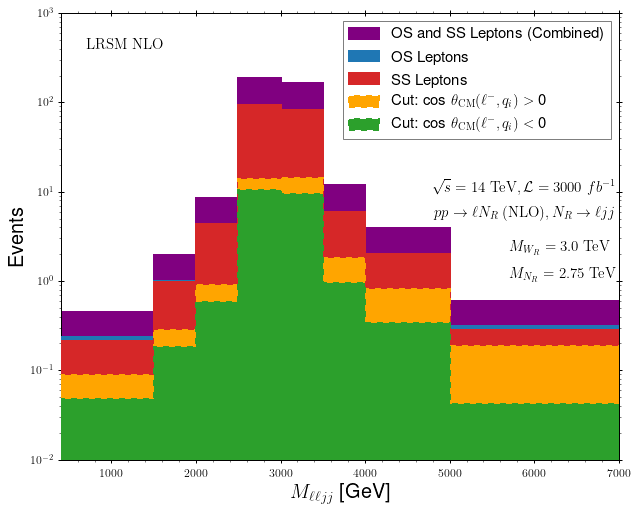

In [15]:
pyplot.rcParams['figure.figsize'] = (10.0, 8.0)
#fig.suptitle(r'No $y_{\ell \ell}$ Cut', fontsize=40)

BinNumber = 12
BinFirst  = 5400.
BinLast   = 6600.

StepSize = (BinLast - BinFirst)/BinNumber
bins = []
bins.append(BinFirst)

for i in range(BinNumber): 
    BinFirst = BinFirst + StepSize
    bins.append(BinFirst)

#bins = [400.0, 1000.0, 1500.0, 2000.0, 2500.0, 3000.0, 3500.0, 4000.0, 4500.0, 5000.0, 5500.0, 6000.0, 7000.0]  # For Mlljj   
bins = [400.0, 1500.0, 2000.0, 2500.0, 3000.0, 3500.0, 4000.0, 5000.0, 7000.0]  # For AFB
    
    
binlabel = []
i=0
for i in range(len(bins)-1):
    binlabel.append((bins[i]+bins[i+1])/2.)
    
    
fig, ax1 = plt.subplots()
fig.set_facecolor('white')
#plt.title(r"$E_6 - \psi$ Model", fontsize=20)
#plt.hist(binlabel,bins=bins,
#             label=r'SM', histtype="stepfilled", rwidth=1.0,
#             weights=NumofEvents_LepPos_SM+NumofEvents_LepNeg_SM, facecolor="black",
#             color=None, edgecolor='black', linewidth=2, linestyle="solid",
#             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=10)

plt.hist(binlabel,bins=bins,
             label=r'OS and SS Leptons (Combined)', histtype="stepfilled", rwidth=1.0,
             weights=NumofEvents_LRSM_Combined, facecolor="purple",
             color=None, edgecolor='purple', linewidth=2, linestyle="solid",
             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=2)
plt.hist(binlabel,bins=bins,
             label=r'OS Leptons', histtype="stepfilled", rwidth=1.0,
             weights=NumofEvents_LRSM_OS, facecolor="tab:blue",
             color=None, edgecolor='tab:blue', linewidth=2, linestyle="solid",
             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=3)
plt.hist(binlabel,bins=bins,
             label=r'SS Leptons', histtype="stepfilled", rwidth=1.0,
             weights=NumofEvents_LRSM_SS, facecolor="tab:red",
             color=None, edgecolor='tab:red', linewidth=2, linestyle="solid",
             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=4)

plt.hist(binlabel,bins=bins,
             label=r'Cut: cos $\theta_{\rm CM}(\ell^-,q_i) > $ 0', histtype="stepfilled", rwidth=1.0,
             weights=NumofEvents_LepPos_LRSM, facecolor="orange",
             color=None, edgecolor='orange', linewidth=2, linestyle="dashed",
             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=7)
plt.hist(binlabel,bins=bins,
             label=r'Cut: cos $\theta_{\rm CM}(\ell^-,q_i) < $ 0', histtype="stepfilled", rwidth=1.0,
             weights=NumofEvents_LepNeg_LRSM, facecolor="tab:green",
             color=None, edgecolor='tab:green', linewidth=2, linestyle="dashed",
             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=8)


#plt.hist(binlabel,bins=bins,
#             label=r'ALRSM (Combined)', histtype="step", rwidth=1.0,
#             weights=NumofEvents_LepPos_ALRSM+NumofEvents_LepNeg_ALRSM, facecolor="cyan",
#             color=None, edgecolor='cyan', linewidth=2, linestyle="solid",
#             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=4)

#plt.hist(binlabel,bins=bins,
#             label=r'Additional SU(2)$_L$ (Combined)', histtype="step", rwidth=1.0,
#             weights=NumofEvents_LepPos_AddSU2L+NumofEvents_LepNeg_AddSU2L, facecolor="blue",
#             color=None, edgecolor='blue', linewidth=2, linestyle="solid",
#             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=11)


#plt.hist(binlabel,bins=bins,
#             label=r'SSM (Combined)', histtype="stepfilled", rwidth=1.0,
#             weights=NumofEvents_LepPos_SSM+NumofEvents_LepNeg_SSM, facecolor="purple",
#             color=None, edgecolor='purple', linewidth=2, linestyle="solid",
#             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=1)

#plt.hist(binlabel,bins=bins,
#             label=r'SSM (cos $\theta > $ 0)', histtype="step", rwidth=1.0,
#             weights=NumofEvents_LepPos_SSM, facecolor="orange",
#             color=None, edgecolor='orange', linewidth=2, linestyle="dashed",
#             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=11)
#plt.hist(binlabel,bins=bins,
#             label=r'SSM (cos $\theta < $ 0)', histtype="step", rwidth=1.0,
#             weights=NumofEvents_LepNeg_SSM, facecolor="darkgoldenrod",
#             color=None, edgecolor='darkgoldenrod', linewidth=2, linestyle="dashed",
#             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=12)


####################### Extra Plots to fix z-order #################

#bins = [5400.0, 5500.0, 5600.0, 5700.0, 5800.0, 5900.0]     
        
#binlabel = []
#i=0
#for i in range(len(bins)-1):
#    binlabel.append((bins[i]+bins[i+1])/2.)

#plt.hist(binlabel,bins=bins,
#             histtype="stepfilled", rwidth=1.0,
#             weights=NumofEvents_LepPos_AddSU2L[0:5]+NumofEvents_LepNeg_AddSU2L[0:5], facecolor="blue",
#             color=None, edgecolor='blue', linewidth=2, linestyle="solid",
#             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=4)


#bins = [5900.0, 6000.0, 6100.0]     
        
#binlabel = []
#i=0
#for i in range(len(bins)-1):
#    binlabel.append((bins[i]+bins[i+1])/2.)


#plt.hist(binlabel,bins=bins,
#             histtype="stepfilled", rwidth=1.0,
#             weights=NumofEvents_LepPos_SSM[5:7]+NumofEvents_LepNeg_SSM[5:7], facecolor="tab:red",
#             color=None, edgecolor='tab:red', linewidth=2, linestyle="solid",
#             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=5)

#plt.hist(binlabel,bins=bins,
#             histtype="stepfilled", rwidth=1.0,
#             weights=NumofEvents_LepPos_LRSM[5:7]+NumofEvents_LepNeg_LRSM[5:7], facecolor="tab:green",
#             color=None, edgecolor='tab:green', linewidth=2, linestyle="solid",
#             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=6)


#BinNumber = 12
#BinFirst  = 5400.
#BinLast   = 6600.

#StepSize = (BinLast - BinFirst)/BinNumber
#bins = []
#bins.append(BinFirst)

#for i in range(BinNumber): 
#    BinFirst = BinFirst + StepSize
#    bins.append(BinFirst)
    

plt.xlabel(r' $M_{\ell \ell jj}$ [GeV]' , fontsize=20)
plt.ylabel('Events' , fontsize=20)
#plt.xscale('log')
plt.yscale('log')

ax1.text(700, 4e2, r"$\displaystyle {\rm\ LRSM\ NLO} $", size=15)
ax1.text(4800, 10, r"$\displaystyle \sqrt{s} = 14 {\rm\ TeV}, \mathcal{L} = 3000\ fb^{-1}$", size=15)
ax1.text(4800, 5, r"$\displaystyle pp \to \ell N_R {\rm\ (NLO)}, N_R \to \ell jj$", size=15)
ax1.text(5700, 2, r"$\displaystyle M_{W_R} = 3.0 {\rm\ TeV}$", size=15)
ax1.text(5700, 1e0, r"$\displaystyle M_{N_R} = 2.75 {\rm\ TeV}$", size=15)

leg = ax1.legend(loc='upper right',fontsize=15) #,ncol=2)#,framealpha=.5)#.get_lines().set_linewidth(0.)
leg.get_frame().set_alpha(0.5)
#leg.get_frame().set_linewidth(0.0)
leg.set_zorder(100)
ax1.set_xlim([min(bins),7000.0])
#ax1.set_ylim([1e-4,1e1])
ax1.tick_params(axis="x", direction="inout", length=6, width=1, color="black",zorder=100)
ax1.tick_params(axis="y", direction="inout", length=6, width=1, color="black",zorder=100)
ax1.tick_params(which="minor", axis="x", direction="out")
ax1.tick_params(which="minor", axis="y", direction="out")

#fig.savefig('/Users/oozdal/Dropbox/WpZp_Project/Second_Paper_WR_bosons/EventsvsMlljj.png') 
#plt.show()

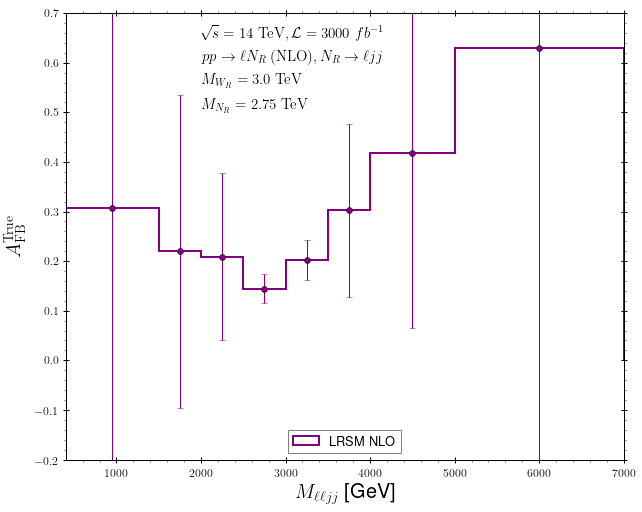

In [17]:
pyplot.rcParams['figure.figsize'] = (10.0, 8.0)
#fig.suptitle(r'No $y_{\ell \ell}$ Cut', fontsize=40)

BinNumber = 12
BinFirst  = 5400.
BinLast   = 6600.

StepSize = (BinLast - BinFirst)/BinNumber
bins = []
bins.append(BinFirst)

for i in range(BinNumber): 
    BinFirst = BinFirst + StepSize
    bins.append(BinFirst)

#bins = [400.0, 1000.0, 1500.0, 2000.0, 2500.0, 3000.0, 3500.0, 4000.0, 4500.0, 5000.0, 5500.0, 6000.0, 7000.0]  # For Mlljj   
bins = [400.0, 1500.0, 2000.0, 2500.0, 3000.0, 3500.0, 4000.0, 5000.0, 7000.0]  # For AFB
    
    
binlabel = []
i=0
for i in range(len(bins)-1):
    binlabel.append((bins[i]+bins[i+1])/2.)


#fig, (ax1, ax2) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [4, 1]})
fig, ax1 = plt.subplots()
fig.set_facecolor('white')
#plt.title(r"$E_6 - \eta$ Model", fontsize=20)
ax1.hist(binlabel,bins=bins,
             label=r"LRSM NLO", histtype="step", rwidth=1.0,
             weights=AFB_LRSM, facecolor="purple",
             color=None, edgecolor='purple', linewidth=2, linestyle="solid",
             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=2)
#ax1.hist(binlabel,bins=bins,
#             label=r"ALRSM $M_{Z^\prime} = 6$ TeV", histtype="step", rwidth=1.0,
#             weights=AFB_ALRSM, facecolor="purple",
#             color=None, edgecolor='purple', linewidth=2, linestyle="solid",
#             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=3)

#ax1.hist(binlabel,bins=bins,
#             label=r"Additional SU(2)$_L$ $M_{Z^\prime} = 6$ TeV", histtype="step", rwidth=1.0,
#             weights=AFB_AddSU2L, facecolor="lime",
#             color=None, edgecolor='blue', linewidth=2, linestyle="solid",
#             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=4)


#ax1.hist(binlabel,bins=bins,
#             label=r"SSM $M_{Z^\prime} = 6$ TeV", histtype="step", rwidth=1.0,
#             weights=AFB_SSM, facecolor="purple",
#             color=None, edgecolor='red', linewidth=2, linestyle="solid",
#             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=5)

#ax1.hist(binlabel,bins=bins,
#             label=r"SM", histtype="step", rwidth=1.0,
#             weights=AFB_SM, facecolor="black",
#             color=None, edgecolor='black', linewidth=2, linestyle="solid",
#             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=1)


#ax1.errorbar(binlabel, AFB_SM, yerr=AFB_SM*unc(AFB_SM,NumofEvents_LepPos_SM+NumofEvents_LepNeg_SM),
#            linestyle='None', marker='o', color='black', zorder = 1)
#ax1.errorbar(binlabel, AFB_SSM, yerr=AFB_SSM*unc(AFB_SSM,(NumofEvents_LepPos_SSM+NumofEvents_LepNeg_SSM)), 
#             linestyle='None', marker='o', color='tab:red', zorder = 6)
ax1.errorbar(binlabel, AFB_LRSM, yerr=AFB_LRSM*unc(AFB_LRSM,(NumofEvents_LepPos_LRSM+NumofEvents_LepNeg_LRSM)), 
             linestyle='None', marker='o', color='purple', zorder = 5)
#ax1.errorbar(binlabel, AFB_ALRSM, yerr=AFB_ALRSM*unc(AFB_ALRSM,(NumofEvents_LepPos_ALRSM+NumofEvents_LepNeg_ALRSM)), 
#             linestyle='None', marker='o', color='purple', zorder = 4)
#ax1.errorbar(binlabel, AFB_AddSU2L, yerr=AFB_AddSU2L*unc(AFB_AddSU2L,(NumofEvents_LepPos_AddSU2L+NumofEvents_LepPos_AddSU2L)), 
#             linestyle='None', marker='o', color='blue', zorder = 3)

#ax1.set_xlabel(r' $M_{\ell \ell}$ [GeV]' , fontsize=20)
ax1.set_ylabel(r'$A_{\rm FB}^{\rm True}$' , fontsize=20)
#ax1.set_yscale('log')


ax1.text(2000, 0.65, r"$\displaystyle \sqrt{s} = 14 {\rm\ TeV}, \mathcal{L} = 3000\ fb^{-1}$", size=15)
ax1.text(2000, 0.60, r"$\displaystyle pp \to \ell N_R {\rm\ (NLO)}, N_R \to \ell jj$", size=15)
ax1.text(2000, 0.55, r"$\displaystyle M_{W_R} = 3.0 {\rm\ TeV}$", size=15)
ax1.text(2000, 0.50, r"$\displaystyle M_{N_R} = 2.75 {\rm\ TeV}$", size=15)


#ax1.text(5800, -0.5, r"$\displaystyle JSD_{\rm SM-LRSM}$ ="+"{:.6}".format(JSD_SMvsLRSM), size=15)
#ax1.text(5800, -0.6, r"$\displaystyle JSD_{\rm SM-ALRSM}$ ="+"{:.6}".format(JSD_SMvsALRSM), size=15)
#ax1.text(5800, -0.7, r"$\displaystyle JSD_{\rm LRSM-ALRSM}$ ="+"{:.6}".format(JSD_LRSMvsALRSM), size=15)


leg = ax1.legend(loc='lower center',fontsize=13) #,ncol=2)#,framealpha=.5)#.get_lines().set_linewidth(0.)
leg.get_frame().set_alpha(0.5)
#leg.get_frame().set_linewidth(0.0)
leg.set_zorder(100)
ax1.set_xlim([min(bins),max(bins)])
ax1.set_ylim([-0.2,0.7])
ax1.tick_params(axis="x", direction="inout", length=6, width=1, color="black",zorder=100)
ax1.tick_params(axis="y", direction="inout", length=6, width=1, color="black",zorder=100)
ax1.tick_params(which="minor", axis="x", direction="out")
ax1.tick_params(which="minor", axis="y", direction="out")

#ax2.hist(binlabel,bins=bins,
#             label=r"$\displaystyle {\rm\ LRSM\ and\ ALRSM} $ ", histtype="step", rwidth=1.0,
#             weights=KLD_LRSMvsALRSM, facecolor="tab:green",
#             color=None, edgecolor='tab:green', linewidth=2, linestyle="solid",
#             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=1)

#ax2.hist(binlabel,bins=bins,
#             label=r"$\displaystyle {\rm\ LRSM\ and\ SSM} $ ", histtype="step", rwidth=1.0,
#             weights=KLD_LRSMvsSSM, facecolor="tab:red",
#             color=None, edgecolor='tab:red', linewidth=2, linestyle="solid",
#             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=2)

#ax2.hist(binlabel,bins=bins,
#             label=r"$\displaystyle {\rm\ ALRSM\ and\ SSM} $ ", histtype="step", rwidth=1.0,
#             weights=KLD_ALRSMvsSSM, facecolor="tab:blue",
#             color=None, edgecolor='tab:blue', linewidth=2, linestyle="solid",
#             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=3)


#ax2.hist(binlabel,bins=bins,
#             label=r'LRSM (Combined)', histtype="step", rwidth=1.0,
#             weights=sig(AFB_SM, AFB_LRSM, (NumofEvents_LepPos_SM+NumofEvents_LepNeg_SM), (NumofEvents_LepPos_LRSM+NumofEvents_LepNeg_LRSM)), facecolor="tab:green",
#             color=None, edgecolor='tab:green', linewidth=2, linestyle="solid",
#             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=1)

#ax2.errorbar(binlabel, sig(AFB_SM, AFB_LRSM, (NumofEvents_LepPos_SM+NumofEvents_LepNeg_SM), (NumofEvents_LepPos_LRSM+NumofEvents_LepNeg_LRSM)), yerr=AFB_LRSM*unc(AFB_LRSM,(NumofEvents_LepPos_LRSM+NumofEvents_LepNeg_LRSM)), linestyle='None', marker='o', color='purple')

#ax2.set_ylim([0,1.5])


ax1.set_xlabel(r' $M_{\ell \ell jj}$ [GeV]' , fontsize=20)
#ax2.set_xlabel(r' $M_{\ell \ell}$ [GeV]' , fontsize=20)
#ax2.set_ylabel(r'${\rm KLD}$' , fontsize=20)

#plt.yscale('log')

#leg = ax2.legend(loc='lower center',fontsize=10)

#fig.tight_layout()

#fig.savefig('/Users/oozdal/Dropbox/WpZp_Project/Second_Paper_WR_bosons/AFBvsMlljj.png')
#plt.show()

Text(0.5,0,' $M_{\\ell \\ell jj}$ [GeV]')

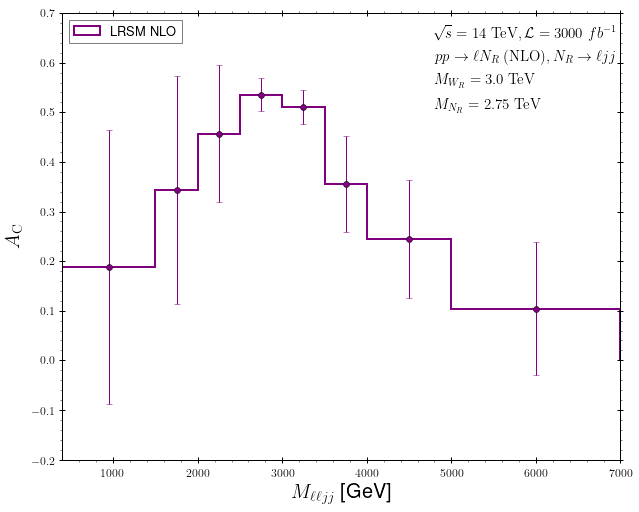

In [52]:
pyplot.rcParams['figure.figsize'] = (10.0, 8.0)
#fig.suptitle(r'No $y_{\ell \ell}$ Cut', fontsize=40)

BinNumber = 12
BinFirst  = 5400.
BinLast   = 6600.

StepSize = (BinLast - BinFirst)/BinNumber
bins = []
bins.append(BinFirst)

for i in range(BinNumber): 
    BinFirst = BinFirst + StepSize
    bins.append(BinFirst)

#bins = [400.0, 1000.0, 1500.0, 2000.0, 2500.0, 3000.0, 3500.0, 4000.0, 4500.0, 5000.0, 5500.0, 6000.0, 7000.0]  # For Mlljj   
bins = [400.0, 1500.0, 2000.0, 2500.0, 3000.0, 3500.0, 4000.0, 5000.0, 7000.0]  # For AFB
    
    
binlabel = []
i=0
for i in range(len(bins)-1):
    binlabel.append((bins[i]+bins[i+1])/2.)


#fig, (ax1, ax2) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [4, 1]})
fig, ax1 = plt.subplots()
fig.set_facecolor('white')
#plt.title(r"$E_6 - \eta$ Model", fontsize=20)
ax1.hist(binlabel,bins=bins,
             label=r"LRSM NLO", histtype="step", rwidth=1.0,
             weights=AC_LRSM, facecolor="purple",
             color=None, edgecolor='purple', linewidth=2, linestyle="solid",
             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=2)
#ax1.hist(binlabel,bins=bins,
#             label=r"ALRSM $M_{Z^\prime} = 6$ TeV", histtype="step", rwidth=1.0,
#             weights=AFB_ALRSM, facecolor="purple",
#             color=None, edgecolor='purple', linewidth=2, linestyle="solid",
#             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=3)

#ax1.hist(binlabel,bins=bins,
#             label=r"Additional SU(2)$_L$ $M_{Z^\prime} = 6$ TeV", histtype="step", rwidth=1.0,
#             weights=AFB_AddSU2L, facecolor="lime",
#             color=None, edgecolor='blue', linewidth=2, linestyle="solid",
#             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=4)


#ax1.hist(binlabel,bins=bins,
#             label=r"SSM $M_{Z^\prime} = 6$ TeV", histtype="step", rwidth=1.0,
#             weights=AFB_SSM, facecolor="purple",
#             color=None, edgecolor='red', linewidth=2, linestyle="solid",
#             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=5)

#ax1.hist(binlabel,bins=bins,
#             label=r"SM", histtype="step", rwidth=1.0,
#             weights=AFB_SM, facecolor="black",
#             color=None, edgecolor='black', linewidth=2, linestyle="solid",
#             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=1)


#ax1.errorbar(binlabel, AFB_SM, yerr=AFB_SM*unc(AFB_SM,NumofEvents_LepPos_SM+NumofEvents_LepNeg_SM),
#            linestyle='None', marker='o', color='black', zorder = 1)
#ax1.errorbar(binlabel, AFB_SSM, yerr=AFB_SSM*unc(AFB_SSM,(NumofEvents_LepPos_SSM+NumofEvents_LepNeg_SSM)), 
#             linestyle='None', marker='o', color='tab:red', zorder = 6)
ax1.errorbar(binlabel, AC_LRSM, yerr=AC_LRSM*unc(AC_LRSM,(NumofEvents_LepPos_LRSM_AC+NumofEvents_LepNeg_LRSM_AC)), 
             linestyle='None', marker='o', color='purple', zorder = 5)
#ax1.errorbar(binlabel, AFB_ALRSM, yerr=AFB_ALRSM*unc(AFB_ALRSM,(NumofEvents_LepPos_ALRSM+NumofEvents_LepNeg_ALRSM)), 
#             linestyle='None', marker='o', color='purple', zorder = 4)
#ax1.errorbar(binlabel, AFB_AddSU2L, yerr=AFB_AddSU2L*unc(AFB_AddSU2L,(NumofEvents_LepPos_AddSU2L+NumofEvents_LepPos_AddSU2L)), 
#             linestyle='None', marker='o', color='blue', zorder = 3)

#ax1.set_xlabel(r' $M_{\ell \ell}$ [GeV]' , fontsize=20)
ax1.set_ylabel(r'$A_{\rm C}$' , fontsize=20)
#ax1.set_yscale('log')


ax1.text(4800, 0.65, r"$\displaystyle \sqrt{s} = 14 {\rm\ TeV}, \mathcal{L} = 3000\ fb^{-1}$", size=15)
ax1.text(4800, 0.60, r"$\displaystyle pp \to \ell N_R {\rm\ (NLO)}, N_R \to \ell jj$", size=15)
ax1.text(4800, 0.55, r"$\displaystyle M_{W_R} = 3.0 {\rm\ TeV}$", size=15)
ax1.text(4800, 0.50, r"$\displaystyle M_{N_R} = 2.75 {\rm\ TeV}$", size=15)


#ax1.text(5800, -0.5, r"$\displaystyle JSD_{\rm SM-LRSM}$ ="+"{:.6}".format(JSD_SMvsLRSM), size=15)
#ax1.text(5800, -0.6, r"$\displaystyle JSD_{\rm SM-ALRSM}$ ="+"{:.6}".format(JSD_SMvsALRSM), size=15)
#ax1.text(5800, -0.7, r"$\displaystyle JSD_{\rm LRSM-ALRSM}$ ="+"{:.6}".format(JSD_LRSMvsALRSM), size=15)


leg = ax1.legend(loc='upper left',fontsize=13) #,ncol=2)#,framealpha=.5)#.get_lines().set_linewidth(0.)
leg.get_frame().set_alpha(0.5)
#leg.get_frame().set_linewidth(0.0)
leg.set_zorder(100)
ax1.set_xlim([min(bins),max(bins)])
ax1.set_ylim([-0.2,0.7])
ax1.tick_params(axis="x", direction="inout", length=6, width=1, color="black",zorder=100)
ax1.tick_params(axis="y", direction="inout", length=6, width=1, color="black",zorder=100)
ax1.tick_params(which="minor", axis="x", direction="out")
ax1.tick_params(which="minor", axis="y", direction="out")

#ax2.hist(binlabel,bins=bins,
#             label=r"$\displaystyle {\rm\ LRSM\ and\ ALRSM} $ ", histtype="step", rwidth=1.0,
#             weights=KLD_LRSMvsALRSM, facecolor="tab:green",
#             color=None, edgecolor='tab:green', linewidth=2, linestyle="solid",
#             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=1)

#ax2.hist(binlabel,bins=bins,
#             label=r"$\displaystyle {\rm\ LRSM\ and\ SSM} $ ", histtype="step", rwidth=1.0,
#             weights=KLD_LRSMvsSSM, facecolor="tab:red",
#             color=None, edgecolor='tab:red', linewidth=2, linestyle="solid",
#             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=2)

#ax2.hist(binlabel,bins=bins,
#             label=r"$\displaystyle {\rm\ ALRSM\ and\ SSM} $ ", histtype="step", rwidth=1.0,
#             weights=KLD_ALRSMvsSSM, facecolor="tab:blue",
#             color=None, edgecolor='tab:blue', linewidth=2, linestyle="solid",
#             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=3)


#ax2.hist(binlabel,bins=bins,
#             label=r'LRSM (Combined)', histtype="step", rwidth=1.0,
#             weights=sig(AFB_SM, AFB_LRSM, (NumofEvents_LepPos_SM+NumofEvents_LepNeg_SM), (NumofEvents_LepPos_LRSM+NumofEvents_LepNeg_LRSM)), facecolor="tab:green",
#             color=None, edgecolor='tab:green', linewidth=2, linestyle="solid",
#             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=1)

#ax2.errorbar(binlabel, sig(AFB_SM, AFB_LRSM, (NumofEvents_LepPos_SM+NumofEvents_LepNeg_SM), (NumofEvents_LepPos_LRSM+NumofEvents_LepNeg_LRSM)), yerr=AFB_LRSM*unc(AFB_LRSM,(NumofEvents_LepPos_LRSM+NumofEvents_LepNeg_LRSM)), linestyle='None', marker='o', color='purple')

#ax2.set_ylim([0,1.5])


ax1.set_xlabel(r' $M_{\ell \ell jj}$ [GeV]' , fontsize=20)
#ax2.set_xlabel(r' $M_{\ell \ell}$ [GeV]' , fontsize=20)
#ax2.set_ylabel(r'${\rm KLD}$' , fontsize=20)

#plt.yscale('log')

#leg = ax2.legend(loc='lower center',fontsize=10)

#fig.tight_layout()

#fig.savefig('/Users/oozdal/Dropbox/WpZp_Project/Second_Paper_WR_bosons/ACvsMlljj.png')
#plt.show()